## Notebook for Session 9

**Note:** This notebook is to be seen as a 'scratch-pad', illustrating the points made in the slides.

In [1]:
!pip install pydot
!pip install pydotplus

In [2]:
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
#import tensorflow_hub as hub
from time import time

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.backend import sparse_categorical_crossentropy

### 1. Generation of Some Synthetic Test Data 

Imagine 400 train and 400 test examples with 10 features each. Each example has **two** labels, label 'a' and label 'b'. We construct these examples synthetically by picking 10 random numbers between 0 and 1, and adding for the examples with label $a =  1$ 0.2 to the first five features, and subtracting 0.2 in those features for examples with label $a = 0$. We do the same for label $b$, where we add/subtract 0.1 to features 6-10. (Obviously, this is just a toy example and the details do not matter - we just want to have some data to explore the formalisms.)

In [3]:
train_1_X = np.array([0.2] * 5 + [0.1] * 5) + np.reshape(np.random.random(1000),[100,10])
train_2_X = np.array([0.2] * 5 + [-0.1] * 5) + np.reshape(np.random.random(1000),[100,10])
train_3_X = np.array([-0.2] * 5 + [0.1] * 5) + np.reshape(np.random.random(1000),[100,10])
train_4_X = np.array([-0.2] * 5 + [-0.1] * 5) + np.reshape(np.random.random(1000),[100,10])

train_X = np.concatenate([train_1_X, train_2_X, train_3_X, train_4_X])

test_1_X = np.array([0.2] * 5 + [0.1] * 5) + np.reshape(np.random.random(1000),[100,10])
test_2_X = np.array([0.2] * 5 + [-0.1] * 5) + np.reshape(np.random.random(1000),[100,10])
test_3_X = np.array([-0.2] * 5 + [0.1] * 5) + np.reshape(np.random.random(1000),[100,10])
test_4_X = np.array([-0.2] * 5 + [-0.1] * 5) + np.reshape(np.random.random(1000),[100,10])

test_X = np.concatenate([test_1_X, test_2_X, test_3_X, test_4_X])

train_1a_y = train_1b_y = train_2a_y = train_3b_y = np.reshape([[1] * 100], [100,1])
train_2b_y = train_3a_y = train_4a_y = train_4b_y = np.reshape([[0] * 100], [100,1])

test_1a_y = test_1b_y = test_2a_y = test_3b_y = np.reshape([[1] * 100], [100,1])
test_2b_y = test_3a_y = test_4a_y = test_4b_y = np.reshape([[0] * 100], [100,1])

train_a_y = np.concatenate([train_1a_y, train_2a_y, train_3a_y, train_4a_y])
train_b_y = np.concatenate([train_1b_y, train_2b_y, train_3b_y, train_4b_y])

test_a_y = np.concatenate([test_1a_y, test_2a_y, test_3a_y, test_4a_y])
test_b_y = np.concatenate([test_1b_y, test_2b_y, test_3b_y, test_4b_y])


Shapes as expected?

In [4]:
np.shape(train_X)

(400, 10)

In [5]:
train_X[:2,:]

array([[0.95851501, 0.61959204, 1.15041516, 0.33136821, 0.74723274,
        0.86813375, 0.31850178, 0.21784756, 0.58501624, 0.61452869],
       [0.91241606, 0.46656918, 1.08347314, 0.4377282 , 0.30392171,
        0.81736764, 1.00788564, 0.52406252, 0.60108814, 0.38926679]])

In [6]:
np.shape(train_a_y)

(400, 1)

In [7]:
train_a_y[:2, :]

array([[1],
       [1]])

Looks good.

### 2. Keras' Functional API Formalism

Keras' Functional API allows us to construct non-sequential models with multiple inputs, multiple outputs, branched models,  etc..

Key aspects:

* start with definition of inputs through Input layer(s)
* define the layers and outputs as:
$$\rm next\_layer\_activations = layer(layer\_parameters) (previous\_layer\_activations)$$
* define the model the the input(s) and output(s).  
* 'compile' the model by specifying loss function(s), metric(s) and the optimizer.  

We first set things up for one binary classification. It is most convenient to define a function called *build_model()* where we can parametrize aspects we want to vary.

In [8]:
def build_model(activation_function='relu', 
                optimizer='adam', 
                kernel_initializer=tf.keras.initializers.he_normal(seed=1), 
                bias_initializer='zeros'):

    # Define Input layer(s)
    input_numbers = tf.keras.layers.Input(shape=(10,), name="input_numbers")

    # Define one hidden layer and act on input
    dense_layer = tf.keras.layers.Dense(10, 
                                        activation=activation_function, 
                                        kernel_initializer=kernel_initializer, 
                                        bias_initializer=bias_initializer,
                                        name='dense') # layer definition
    dense_output = dense_layer(input_numbers)  # layer acting on previous layer's output
    
    # Define one hidden layer and act on input
    dense_layer_2 = tf.keras.layers.Dense(10, 
                                        activation=activation_function, 
                                        kernel_initializer=kernel_initializer, 
                                        bias_initializer=bias_initializer,
                                        name='dense_2') # layer definition
    dense_output_2 = dense_layer_2(dense_output)  # layer acting on previous layer's output

    

    # Define classification layer and act on previous output to classify examples
    classification_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='classification') # layer definition
    classification_output = classification_layer(dense_output_2)   # layer acting on previous layer's output

    # Build and compile model
    model = tf.keras.models.Model(input_numbers, classification_output)
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return model

model = build_model()


model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_numbers (InputLayer)   [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
classification (Dense)       (None, 1)                 11        
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________


Easy!   

**Question:** Do the dimensions look right? 

### 3.  Training Optimizations

Great, let's do some experimenting. We run the model above for the synthetic data set we defined, only considering the first label, and look at a few variations. Specifically, let's play with:

* the **activation function** in the hidden layer     
* the **initialization**    
* the **optimizer**

We run everything for 40 epochs and compare the results. (We split the training into two parts to cut down on reporting. 'verbose=0' supresses output. But we still want to see the final loss so we add one epoch with 'verbose=1'.)

In [9]:
model_1 = build_model()  # This one should be good...

model_1.fit(
        train_X,
        train_a_y,
        validation_data=[test_X, test_a_y],
        epochs=39,
        verbose=0)

model_1.fit(
        train_X,
        train_a_y,
        validation_data=[test_X, test_a_y],
        epochs=1,
        verbose=1)

Train on 400 samples, validate on 400 samples
400/400 [==============================] - 0s 557us/sample - loss: 0.2163 - val_loss: 0.2316


This is our supposed best setup, and it defines our baselines. 

Let's veer off and see how loss, etc. change. First, we use $tanh()$ as opposed to $relu()$:

In [10]:
model_2 = build_model(activation_function='tanh')  

model_2.fit(
        train_X,
        train_a_y,
        validation_data=[test_X, test_a_y],
        epochs=39,
        verbose=0)

model_2.fit(
        train_X,
        train_a_y,
        validation_data=[test_X, test_a_y],
        epochs=1,
        verbose=1)

Train on 400 samples, validate on 400 samples
400/400 [==============================] - 0s 306us/sample - loss: 0.1836 - val_loss: 0.1957


A bit worse. [Of course, the initialization is random, so things may be different on future runs.]

Next, we change the optimizer to stochastic gradient descent:

In [11]:
model_3 = build_model(optimizer='sgd')  

model_3.fit(
        train_X,
        train_a_y,
        validation_data=[test_X, test_a_y],
        epochs=39,
        verbose=0)

model_3.fit(
        train_X,
        train_a_y,
        validation_data=[test_X, test_a_y],
        epochs=1,
        verbose=1)

Train on 400 samples, validate on 400 samples
400/400 [==============================] - 0s 341us/sample - loss: 0.3994 - val_loss: 0.4170


A lot worse!!

Going back to the activation function, what about $sigmoid()$?

In [12]:
model_4 = build_model(activation_function='sigmoid')  

model_4.fit(
        train_X,
        train_a_y,
        validation_data=[test_X, test_a_y],
        epochs=39,
        verbose=0)

model_4.fit(
        train_X,
        train_a_y,
        validation_data=[test_X, test_a_y],
        epochs=1,
        verbose=1)

Train on 400 samples, validate on 400 samples
400/400 [==============================] - 0s 513us/sample - loss: 0.5993 - val_loss: 0.5916


Not good!

Lastly, what about choosing general random matrix initialization as opposed to He/Xavier? 

In [13]:
model_5 = build_model(kernel_initializer='random_normal')  

model_5.fit(
        train_X,
        train_a_y,
        validation_data=[test_X, test_a_y],
        epochs=39,
        verbose=0)

model_5.fit(
        train_X,
        train_a_y,
        validation_data=[test_X, test_a_y],
        epochs=1,
        verbose=1)

Train on 400 samples, validate on 400 samples
400/400 [==============================] - 0s 407us/sample - loss: 0.1777 - val_loss: 0.1816


A bit worse too.

**Critical Note:** We were cheating a bit here! There is a stochastic component and if one re-reruns the cells results will differ. In fact, *in this simple case* the last configuration is often the best.

### 4. Splitting Models - Multiple Outputs

Now, let's go back to our dataset and let's try to predict two labels. We want to model that by *splitting* the model, i.e., two distinct hidden layers act on the input, and we use those two branches to predict the two labels:  

In [14]:
# Define Input layer(s)
input_numbers = tf.keras.layers.Input(shape=(10,), name="input_numbers")

# Define separate hidden layers and acting on (same!) input
dense_layer_1 = tf.keras.layers.Dense(10, activation='relu', name='dense_1')
dense_layer_2 = tf.keras.layers.Dense(10, activation='relu', name='dense_2')

dense_output_1 = dense_layer_1(input_numbers)     # hideen layer 1 acting on input
dense_output_2 = dense_layer_2(input_numbers)     # hideen layer 2 acting on input



# Define classification layer and act on previous output to classify examples
classification_layer_1 = tf.keras.layers.Dense(1, 
                            activation='sigmoid', name='classification_1')  # classification layer 1 for first branch

classification_layer_2 = tf.keras.layers.Dense(1, 
                            activation='sigmoid', name='classification_2')  # classification layer 2 for second branch


classification_output_1 = classification_layer_1(dense_output_1)
classification_output_2 = classification_layer_2(dense_output_2)



# Build and compile model

model_input = input_numbers
model_output = [classification_output_1, classification_output_2]
losses = ['binary_crossentropy', 'binary_crossentropy']
metrics = ['acc', 'acc']

model = tf.keras.models.Model(model_input, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)




In [15]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_numbers (InputLayer)      [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10)           110         input_numbers[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 10)           110         input_numbers[0][0]              
__________________________________________________________________________________________________
classification_1 (Dense)        (None, 1)            11          dense_1[0][0]                    
____________________________________________________________________________________________

We can also take a look at how the layers are connected.

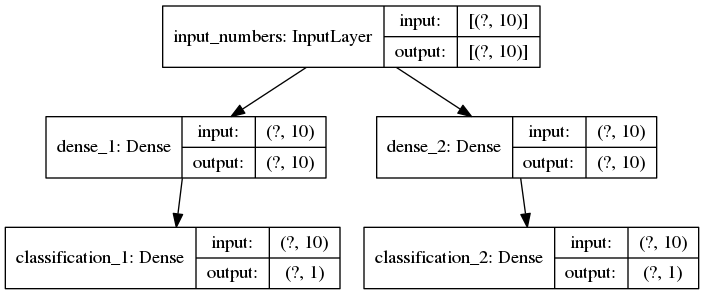

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

Previously, when we ran `model.fit()` we created a keras history object.  We can use that now in order to examine model training in more detail.

In [17]:
history = model.fit(
    train_X,
    [train_a_y, train_b_y],
    validation_data=[test_X, [test_a_y, test_b_y]],
    epochs=150,
    verbose=1
)

Train on 400 samples, validate on 400 samples
Epoch 1/150
400/400 [==============================] - 1s 3ms/sample - loss: 1.4742 - classification_1_loss: 0.7553 - classification_2_loss: 0.7153 - classification_1_acc: 0.4750 - classification_2_acc: 0.4500 - val_loss: 1.4515 - val_classification_1_loss: 0.7289 - val_classification_2_loss: 0.7170 - val_classification_1_acc: 0.4775 - val_classification_2_acc: 0.4775
Epoch 2/150
400/400 [==============================] - 0s 527us/sample - loss: 1.4337 - classification_1_loss: 0.7251 - classification_2_loss: 0.7108 - classification_1_acc: 0.4900 - classification_2_acc: 0.4625 - val_loss: 1.4172 - val_classification_1_loss: 0.7014 - val_classification_2_loss: 0.7124 - val_classification_1_acc: 0.5100 - val_classification_2_acc: 0.4850
Epoch 3/150
400/400 [==============================] - 0s 524us/sample - loss: 1.4019 - classification_1_loss: 0.6938 - classification_2_loss: 0.7054 - classification_1_acc: 0.5550 - classification_2_acc: 0.482

Epoch 23/150
400/400 [==============================] - 0s 407us/sample - loss: 1.0261 - classification_1_loss: 0.3904 - classification_2_loss: 0.6343 - classification_1_acc: 0.8675 - classification_2_acc: 0.7050 - val_loss: 1.0285 - val_classification_1_loss: 0.3900 - val_classification_2_loss: 0.6462 - val_classification_1_acc: 0.8700 - val_classification_2_acc: 0.6650
Epoch 24/150
400/400 [==============================] - 0s 346us/sample - loss: 1.0113 - classification_1_loss: 0.3779 - classification_2_loss: 0.6319 - classification_1_acc: 0.8700 - classification_2_acc: 0.7050 - val_loss: 1.0140 - val_classification_1_loss: 0.3803 - val_classification_2_loss: 0.6423 - val_classification_1_acc: 0.8750 - val_classification_2_acc: 0.6700
Epoch 25/150
400/400 [==============================] - 0s 224us/sample - loss: 0.9975 - classification_1_loss: 0.3699 - classification_2_loss: 0.6243 - classification_1_acc: 0.8725 - classification_2_acc: 0.7075 - val_loss: 1.0005 - val_classification

Epoch 45/150
400/400 [==============================] - 0s 439us/sample - loss: 0.8170 - classification_1_loss: 0.2664 - classification_2_loss: 0.5573 - classification_1_acc: 0.8975 - classification_2_acc: 0.7325 - val_loss: 0.8319 - val_classification_1_loss: 0.2675 - val_classification_2_loss: 0.5747 - val_classification_1_acc: 0.9050 - val_classification_2_acc: 0.7200
Epoch 46/150
400/400 [==============================] - 0s 402us/sample - loss: 0.8112 - classification_1_loss: 0.2572 - classification_2_loss: 0.5494 - classification_1_acc: 0.8950 - classification_2_acc: 0.7425 - val_loss: 0.8264 - val_classification_1_loss: 0.2638 - val_classification_2_loss: 0.5728 - val_classification_1_acc: 0.9000 - val_classification_2_acc: 0.7250
Epoch 47/150
400/400 [==============================] - 0s 359us/sample - loss: 0.8051 - classification_1_loss: 0.2549 - classification_2_loss: 0.5454 - classification_1_acc: 0.8975 - classification_2_acc: 0.7450 - val_loss: 0.8211 - val_classification

Epoch 67/150
400/400 [==============================] - 0s 309us/sample - loss: 0.7236 - classification_1_loss: 0.2192 - classification_2_loss: 0.5154 - classification_1_acc: 0.9175 - classification_2_acc: 0.7525 - val_loss: 0.7526 - val_classification_1_loss: 0.2211 - val_classification_2_loss: 0.5391 - val_classification_1_acc: 0.9100 - val_classification_2_acc: 0.7450
Epoch 68/150
400/400 [==============================] - 0s 402us/sample - loss: 0.7191 - classification_1_loss: 0.2129 - classification_2_loss: 0.5041 - classification_1_acc: 0.9150 - classification_2_acc: 0.7625 - val_loss: 0.7502 - val_classification_1_loss: 0.2191 - val_classification_2_loss: 0.5375 - val_classification_1_acc: 0.9125 - val_classification_2_acc: 0.7425
Epoch 69/150
400/400 [==============================] - 0s 399us/sample - loss: 0.7168 - classification_1_loss: 0.2220 - classification_2_loss: 0.5021 - classification_1_acc: 0.9150 - classification_2_acc: 0.7725 - val_loss: 0.7480 - val_classification

Epoch 89/150
400/400 [==============================] - 0s 292us/sample - loss: 0.6707 - classification_1_loss: 0.1921 - classification_2_loss: 0.4864 - classification_1_acc: 0.9200 - classification_2_acc: 0.7750 - val_loss: 0.7116 - val_classification_1_loss: 0.1941 - val_classification_2_loss: 0.5224 - val_classification_1_acc: 0.9225 - val_classification_2_acc: 0.7425
Epoch 90/150
400/400 [==============================] - 0s 294us/sample - loss: 0.6709 - classification_1_loss: 0.1883 - classification_2_loss: 0.4809 - classification_1_acc: 0.9225 - classification_2_acc: 0.7550 - val_loss: 0.7125 - val_classification_1_loss: 0.1944 - val_classification_2_loss: 0.5221 - val_classification_1_acc: 0.9250 - val_classification_2_acc: 0.7475
Epoch 91/150
400/400 [==============================] - 0s 328us/sample - loss: 0.6667 - classification_1_loss: 0.1907 - classification_2_loss: 0.4757 - classification_1_acc: 0.9200 - classification_2_acc: 0.7650 - val_loss: 0.7093 - val_classification

Epoch 111/150
400/400 [==============================] - 0s 397us/sample - loss: 0.6375 - classification_1_loss: 0.1718 - classification_2_loss: 0.4759 - classification_1_acc: 0.9200 - classification_2_acc: 0.7725 - val_loss: 0.6895 - val_classification_1_loss: 0.1789 - val_classification_2_loss: 0.5148 - val_classification_1_acc: 0.9250 - val_classification_2_acc: 0.7400
Epoch 112/150
400/400 [==============================] - 0s 413us/sample - loss: 0.6363 - classification_1_loss: 0.1713 - classification_2_loss: 0.4589 - classification_1_acc: 0.9200 - classification_2_acc: 0.7700 - val_loss: 0.6891 - val_classification_1_loss: 0.1782 - val_classification_2_loss: 0.5146 - val_classification_1_acc: 0.9250 - val_classification_2_acc: 0.7425
Epoch 113/150
400/400 [==============================] - 0s 402us/sample - loss: 0.6359 - classification_1_loss: 0.1689 - classification_2_loss: 0.4601 - classification_1_acc: 0.9200 - classification_2_acc: 0.7725 - val_loss: 0.6872 - val_classificat

Epoch 133/150
400/400 [==============================] - 0s 533us/sample - loss: 0.6169 - classification_1_loss: 0.1593 - classification_2_loss: 0.4571 - classification_1_acc: 0.9250 - classification_2_acc: 0.7700 - val_loss: 0.6754 - val_classification_1_loss: 0.1670 - val_classification_2_loss: 0.5113 - val_classification_1_acc: 0.9375 - val_classification_2_acc: 0.7425
Epoch 134/150
400/400 [==============================] - 0s 411us/sample - loss: 0.6158 - classification_1_loss: 0.1540 - classification_2_loss: 0.4635 - classification_1_acc: 0.9250 - classification_2_acc: 0.7675 - val_loss: 0.6761 - val_classification_1_loss: 0.1677 - val_classification_2_loss: 0.5113 - val_classification_1_acc: 0.9375 - val_classification_2_acc: 0.7425
Epoch 135/150
400/400 [==============================] - 0s 353us/sample - loss: 0.6180 - classification_1_loss: 0.1551 - classification_2_loss: 0.4575 - classification_1_acc: 0.9225 - classification_2_acc: 0.7575 - val_loss: 0.6779 - val_classificat

In [18]:
# the keys in the history object
history.history.keys()

dict_keys(['loss', 'classification_1_loss', 'classification_2_loss', 'classification_1_acc', 'classification_2_acc', 'val_loss', 'val_classification_1_loss', 'val_classification_2_loss', 'val_classification_1_acc', 'val_classification_2_acc'])

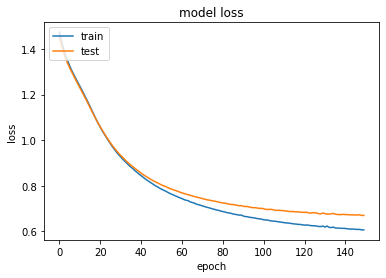

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

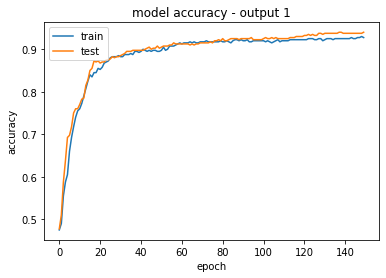

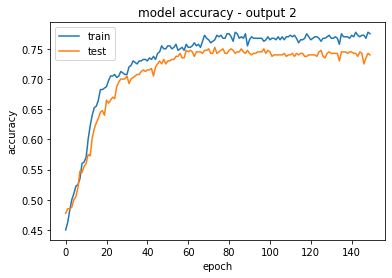

In [20]:
# summarize history for accuracy
plt.plot(history.history['classification_1_acc'])
plt.plot(history.history['val_classification_1_acc'])
plt.title('model accuracy - output 1')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['classification_2_acc'])
plt.plot(history.history['val_classification_2_acc'])
plt.title('model accuracy - output 2')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Questions:**
* Does it surprise you that the loss for label 1 is smaller than the loss for label 2?    
* Quick side check... do we overtrain?    

### 5. Custom Layers

Let's define a simple custom layer which is nothing but an affine transformation followed by a relu activation. We need to define:
* \_\_init\_\_()      
* build()   
* call()   
* compute_output_shape()   

In [21]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

class MyStupidDenseLayer(Layer):

    def __init__(self, output_dim, **kwargs):   
        self.output_dim = output_dim
        
        super(MyStupidDenseLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.W = self.add_variable("W",
                                    shape=[int(input_shape[1]),self.output_dim], 
                                   initializer=tf.keras.initializers.GlorotNormal(),
                                   trainable=True)
        self.b = self.add_variable("b",
                                    shape=[self.output_dim, ], 
                                   initializer=tf.initializers.zeros(),
                                   trainable=True)
        super(MyStupidDenseLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return tf.nn.relu(tf.tensordot(x, self.W, axes=[[1],[0]]) + self.b)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

Let's use our custom layer in the same architecture. 

In [22]:
# Define Input layer(s)
input_numbers = tf.keras.layers.Input(shape=(10,), name="input_numbers")

# Define separate hidden layers and acting on (same!) input
dense_layer_1 = MyStupidDenseLayer(10, name='dense_1')
dense_layer_2 = MyStupidDenseLayer(10, name='dense_2')

dense_output_1 = dense_layer_1(input_numbers)
dense_output_2 = dense_layer_2(input_numbers)



# Define classification layer and act on previous output to classify examples
classification_layer_1 = tf.keras.layers.Dense(1, 
                            activation='sigmoid', name='classification_1')

classification_layer_2 = tf.keras.layers.Dense(1, 
                            activation='sigmoid', name='classification_2')


classification_output_1 = classification_layer_1(dense_output_1)
classification_output_2 = classification_layer_2(dense_output_2)



# Build and compile model

model_input = input_numbers
model_output = [classification_output_1, classification_output_2]
losses = ['binary_crossentropy', 'binary_crossentropy']
metrics = ['acc', 'acc']

model = tf.keras.models.Model(model_input, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)




Instructions for updating:
Please use `layer.add_weight` method instead.


In [23]:
model.fit(
    train_X,
    [train_a_y, train_b_y],
    validation_data=[test_X, [test_a_y, test_b_y]],
    epochs=149,
    verbose=0
)

model.fit(
    train_X,
    [train_a_y, train_b_y],
    validation_data=[test_X, [test_a_y, test_b_y]],
    epochs=1,
    verbose=1
)

Train on 400 samples, validate on 400 samples
400/400 [==============================] - 0s 451us/sample - loss: 0.6234 - classification_1_loss: 0.1622 - classification_2_loss: 0.4624 - classification_1_acc: 0.9275 - classification_2_acc: 0.7575 - val_loss: 0.6792 - val_classification_1_loss: 0.1651 - val_classification_2_loss: 0.5180 - val_classification_1_acc: 0.9400 - val_classification_2_acc: 0.7400


Close enough. So the custom layer works exactly as expected.


### 6. Sharing & Freezing Weights 


Let's define an identical model. The weights for this model will be re-initialized, so upon training for 1 epoch the loss will be much higher than after 150 epochs for the original model: 

In [24]:
# Define Input layer(s)
input_numbers = tf.keras.layers.Input(shape=(10,), name="input_numbers")

# Define separate hidden layers and acting on (same!) input
dense_layer_1 = MyStupidDenseLayer(10, name='dense_1')
dense_layer_2 = MyStupidDenseLayer(10, name='dense_2')

dense_output_1 = dense_layer_1(input_numbers)
dense_output_2 = dense_layer_2(input_numbers)



# Define classification layer and act on previous output to classify examples
classification_layer_1 = tf.keras.layers.Dense(1, 
                            activation='sigmoid', name='classification_1')

classification_layer_2 = tf.keras.layers.Dense(1, 
                            activation='sigmoid', name='classification_2')


classification_output_1 = classification_layer_1(dense_output_1)
classification_output_2 = classification_layer_2(dense_output_2)



# Build and compile model

model_input = input_numbers
model_output = [classification_output_1, classification_output_2]
losses = ['binary_crossentropy', 'binary_crossentropy']
metrics = ['acc', 'acc']

model_mirror = tf.keras.models.Model(model_input, model_output)
model_mirror.compile(loss=losses,  optimizer='adam', metrics=metrics)




In [25]:
model_mirror.fit(
    train_X,
    [train_a_y, train_b_y],
    validation_data=[test_X, [test_a_y, test_b_y]],
    epochs=1,
    verbose=1
)

Train on 400 samples, validate on 400 samples
400/400 [==============================] - 1s 4ms/sample - loss: 1.4105 - classification_1_loss: 0.6624 - classification_2_loss: 0.7464 - classification_1_acc: 0.6275 - classification_2_acc: 0.4150 - val_loss: 1.3963 - val_classification_1_loss: 0.6633 - val_classification_2_loss: 0.7272 - val_classification_1_acc: 0.6050 - val_classification_2_acc: 0.4275


Indeed, this model would make very different predictions - the loss is ~1.4 vs ~0.6. No surprise, obviously, as this model has not been trained.

What if we manually set the the weights of the second model to the weights of the first? Let's look at the layers for both models and then copy the weights:

In [26]:
model.layers

Let's look at one layer in more detail:

In [27]:
len(model.layers[1].get_weights())

2

Why would that be? No magic.. weights and biases of layer!

In [28]:
np.shape(model.layers[1].get_weights()[0])

(10, 10)

In [29]:
np.shape(model.layers[1].get_weights()[1])

(10,)

Cool. What is the name of the layer?

In [30]:
model.layers[1].name

'dense_1'

Correct. Is it trainable?

In [31]:
model.layers[1].trainable

True

Great. Are the layers of the second model essentially the same?

In [32]:
model_mirror.layers

Yup. (We could look at shapes, etc, but won't do that now.) Now we set the second model's weights to equal the first model's trained weights:

In [33]:
model_mirror.layers[1].set_weights(model.layers[1].get_weights())
model_mirror.layers[2].set_weights(model.layers[2].get_weights())
model_mirror.layers[3].set_weights(model.layers[3].get_weights())
model_mirror.layers[4].set_weights(model.layers[4].get_weights())

**Question:** Why don't we set the weights for layer 0?

Okay. What is the loss now for the mirror model? 

In [34]:
model_mirror.fit(
    train_X,
    [train_a_y, train_b_y],
    validation_data=[test_X, [test_a_y, test_b_y]],
    epochs=1,
    verbose=1
)

Train on 400 samples, validate on 400 samples
400/400 [==============================] - 0s 462us/sample - loss: 0.6237 - classification_1_loss: 0.1559 - classification_2_loss: 0.4626 - classification_1_acc: 0.9250 - classification_2_acc: 0.7550 - val_loss: 0.6807 - val_classification_1_loss: 0.1675 - val_classification_2_loss: 0.5178 - val_classification_1_acc: 0.9350 - val_classification_2_acc: 0.7400


Cool! Essentially the same as for the original one! (Not a surprise actually... but great that it works.)

Let's now turn to **freezing** layers. For example, you may want to copy weights from another model but hold those weights fixed upon further training. To test this, we will do a simple toy exercise: freeze a layer of the second model and train it further. Let's compare some weights before and after training. 

We start by defining a new model that again has the same architecture, **but we set the trainable-parameter for one layer to False**: 

In [35]:
# Define Input layer(s)
input_numbers = tf.keras.layers.Input(shape=(10,), name="input_numbers")

# Define separate hidden layers and acting on (same!) input
dense_layer_1 = MyStupidDenseLayer(10, name='dense_1')

dense_layer_2 = MyStupidDenseLayer(10, name='dense_2')
dense_layer_2.trainable = False                                   # Freeze this layer

dense_output_1 = dense_layer_1(input_numbers)
dense_output_2 = dense_layer_2(input_numbers)



# Define classification layer and act on previous output to classify examples
classification_layer_1 = tf.keras.layers.Dense(1, 
                            activation='sigmoid', name='classification_1')

classification_layer_2 = tf.keras.layers.Dense(1, 
                            activation='sigmoid', name='classification_2')



classification_output_1 = classification_layer_1(dense_output_1)
classification_output_2 = classification_layer_2(dense_output_2)



# Build and compile model

model_input = input_numbers
model_output = [classification_output_1, classification_output_2]
losses = ['binary_crossentropy', 'binary_crossentropy']
metrics = ['acc', 'acc']

model_mirror_2 = tf.keras.models.Model(model_input, model_output)
model_mirror_2.compile(loss=losses,  optimizer='adam', metrics=metrics)


Next, we again set the weights to mirror the first model:

In [36]:
model_mirror_2.layers[1].set_weights(model.layers[1].get_weights())
model_mirror_2.layers[2].set_weights(model.layers[2].get_weights())
model_mirror_2.layers[3].set_weights(model.layers[3].get_weights())
model_mirror_2.layers[4].set_weights(model.layers[4].get_weights())

What are (some of) the weights now, before we train further?

In [37]:
model_mirror_2.layers[1].get_weights()[0][:3, :3]

array([[ 0.61718553, -0.41603836,  0.918802  ],
       [ 0.7583694 , -0.00405855,  0.30756676],
       [ 0.5066098 , -0.1176214 ,  0.38368145]], dtype=float32)

In [38]:
model_mirror_2.layers[2].get_weights()[0][:3, :3]

array([[-0.04679712, -0.1315682 , -0.15096872],
       [-0.4433521 , -0.17600217,  0.3507804 ],
       [-0.352371  ,  0.09641659,  0.28120884]], dtype=float32)

We will compare that with the values post further training. Let's also check the 'trainable' settings:

In [39]:
model_mirror_2.layers[1].trainable

True

In [40]:
model_mirror_2.layers[2].trainable

False

Good, so it shows that one hidden layer supposedly is trainable, the other one is not. Is that true? We train more and compare weights compared to what they were:

In [41]:
model_mirror_2.fit(
    train_X,
    [train_a_y, train_b_y],
    validation_data=[test_X, [test_a_y, test_b_y]],
    epochs=40,
    verbose=0
)
model_mirror_2.fit(
    train_X,
    [train_a_y, train_b_y],
    validation_data=[test_X, [test_a_y, test_b_y]],
    epochs=1,
    verbose=1
)

Train on 400 samples, validate on 400 samples
400/400 [==============================] - 0s 389us/sample - loss: 0.6049 - classification_1_loss: 0.1506 - classification_2_loss: 0.4509 - classification_1_acc: 0.9325 - classification_2_acc: 0.7600 - val_loss: 0.6698 - val_classification_1_loss: 0.1556 - val_classification_2_loss: 0.5180 - val_classification_1_acc: 0.9425 - val_classification_2_acc: 0.7400


In [42]:
model_mirror_2.layers[1].get_weights()[0][:3, :3]

array([[ 0.6272421 , -0.41039306,  0.92152977],
       [ 0.75836545, -0.01142356,  0.3168626 ],
       [ 0.5398538 , -0.12424072,  0.42135727]], dtype=float32)

These weights **did change**.

In [43]:
model_mirror_2.layers[2].get_weights()[0][:3, :3]

array([[-0.04679712, -0.1315682 , -0.15096872],
       [-0.4433521 , -0.17600217,  0.3507804 ],
       [-0.352371  ,  0.09641659,  0.28120884]], dtype=float32)

These weights **did not change**. So here we could see layer freezing at work!